# Import dependencies and determine working directory

In [1]:
# Import libraries
from os import path
import numpy as np
import pandas as pd
from sklearn.externals import joblib
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support as score
import matplotlib.pyplot as plt
import time
import cv2

In [24]:
# Importing the Keras libraries and packages
import keras
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras import initializers

# Load training data

In [3]:
# Load data from pickled file 
filename_in__images_train = path.join('..', '04_processed_data','mini_images_train.pkl')
filename_in__emotions_train = path.join('..', '04_processed_data','mini_emotions_train.pkl')

X_train = joblib.load(filename_in__images_train)
y_train = joblib.load(filename_in__emotions_train)

In [4]:
filename_in__images_test = path.join('..', '04_processed_data','mini_images_test.pkl')
filename_in__emotions_test = path.join('..', '04_processed_data','mini_emotions_test.pkl')

X_test = joblib.load(filename_in__images_test)
y_test = joblib.load(filename_in__emotions_test)

In [39]:
filename_in__sequence_test = path.join('..', '04_processed_data','mini_sequence_test.pkl')
sequence_test = joblib.load(filename_in__sequence_test)

In [5]:
X_train = np.divide(X_train, 255)
X_test = np.divide(X_test, 255)

# Build a CNN model

In [6]:
def reshape_image(array_in):
    image_side = int(array_in.shape[1]**0.5)
    array_2d = []
    for row in array_in: 
        array_2d.append(np.reshape(row, (image_side, image_side, 1) ) )
    array_2d = np.array(array_2d)
    return array_2d

In [7]:
# reshape data
X_train = reshape_image(X_train)
X_test = reshape_image(X_test)

In [8]:
# get parameters for input data 
input_shape = (X_train.shape[1] , X_train.shape[2], X_train.shape[3])
num_classes = len(set(y_train))

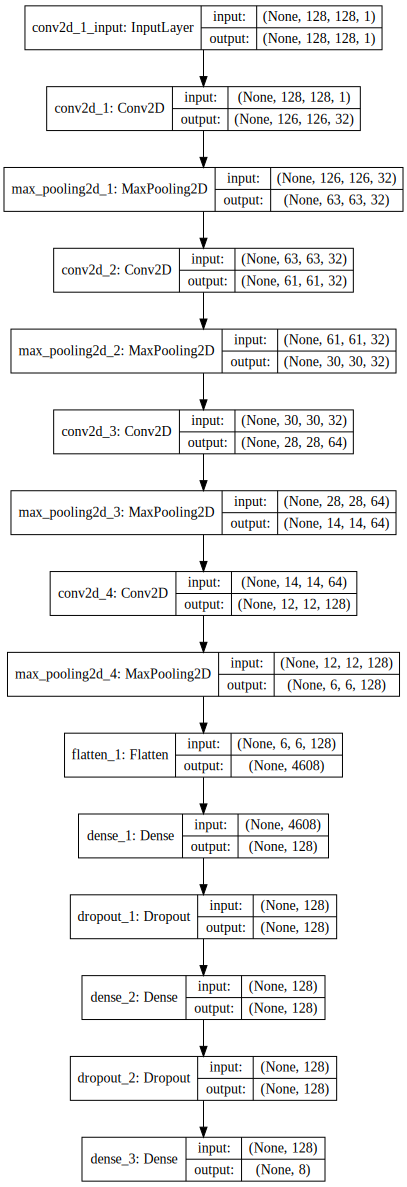

In [9]:
def construct_architecture_1(input_shape, num_classes):
    # instantiate model
    dnn_model = Sequential()
    # add convolution and pooling layers
    dnn_model.add( Conv2D(32, kernel_size=(3, 3), input_shape = input_shape, activation = 'elu') )
    dnn_model.add( MaxPooling2D(pool_size=(2, 2)) )
    
    dnn_model.add( Conv2D(32, kernel_size=(3, 3), activation = 'elu') )
    dnn_model.add( MaxPooling2D(pool_size=(2, 2)) )
              
    dnn_model.add( Conv2D(64, kernel_size=(3, 3), activation = 'elu') )
    dnn_model.add( MaxPooling2D(pool_size=(2, 2)) )
              
    dnn_model.add( Conv2D(128, kernel_size=(3, 3), activation = 'elu') )
    dnn_model.add( MaxPooling2D(pool_size=(2, 2)) )
    
    dnn_model.add( Flatten() )
    
    # add dense layers
    dnn_model.add( Dense(128, activation ='elu' ) )
    dnn_model.add( Dropout(0.4) )
    dnn_model.add( Dense(128, activation ='elu' ) )
    dnn_model.add( Dropout(0.4) )
    # define output layer
    dnn_model.add( Dense(num_classes, activation='softmax') )
    # compile model
    dnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return dnn_model

# Create model instance
classifier_01 = construct_architecture_1(input_shape, num_classes)

# Vizualize network achitecture
SVG(model_to_dot(classifier_01, show_shapes=True, show_layer_names=True, rankdir='TB').create(prog='dot', format='svg'))

# Run model

In [10]:
def save_files(classifier, history, filename):
    
    print(history.history)
    # create filepaths
    classifier_name = filename + '_mini_model.h5'
    filename_out__classifier = path.join('..', '04_processed_data', classifier_name)
    # save model
    classifier.save(filename_out__classifier)

    print('Model saved')

In [11]:
# create a function that fits to training data
def run_model(classifier, filename):
    startTime = time.clock()
    
    # Define callbacks
    early_stopping_monitor = EarlyStopping(monitor='val_acc', patience=10)
    callbacks = [early_stopping_monitor]
    
    # Fit classifier
    history = classifier.fit(X_train, pd.get_dummies(y_train), epochs=50, 
                            batch_size = 128, validation_split=0.1, callbacks=callbacks)
    endTime = time.clock()
    print("Model is trained in {0} seconds!".format(endTime - startTime))
    
    # Saving the trained model
    print("Saving model...")
    save_files(classifier, history, filename)
    
    return classifier

In [12]:
classifier_01 = run_model(classifier_01, 'classifier_01')

Train on 1058 samples, validate on 118 samples
Epoch 1/50
1058/1058 [==============================] - 56s 53ms/step - loss: 1.7400 - acc: 0.4206 - val_loss: 1.7101 - val_acc: 0.4915
Epoch 2/50
1058/1058 [==============================] - 57s 54ms/step - loss: 1.5154 - acc: 0.5180 - val_loss: 1.5661 - val_acc: 0.4915
Epoch 3/50
1058/1058 [==============================] - 52s 49ms/step - loss: 1.2093 - acc: 0.6474 - val_loss: 1.2739 - val_acc: 0.6441
Epoch 4/50
1058/1058 [==============================] - 55s 52ms/step - loss: 0.9487 - acc: 0.7231 - val_loss: 1.1497 - val_acc: 0.6864
Epoch 5/50
1058/1058 [==============================] - 58s 55ms/step - loss: 0.8513 - acc: 0.7268 - val_loss: 1.2006 - val_acc: 0.6610
Epoch 6/50
1058/1058 [==============================] - 54s 51ms/step - loss: 0.7007 - acc: 0.7845 - val_loss: 0.9358 - val_acc: 0.6864
Epoch 7/50
1058/1058 [==============================] - 56s 53ms/step - loss: 0.6497 - acc: 0.7911 - val_loss: 0.9628 - val_acc: 0.6695
E

## Evaluate model performance

In [13]:
# Predict the labels
test_prediction_1 = classifier_01.predict_classes(X_test)

In [14]:
# Create labels
labels = [0,1,2,3,4,5,6,7]

In [15]:
test_cm_1 = metrics.confusion_matrix(y_test, test_prediction_1, labels=labels)
print('For the confusion matrix, rows correspond to actual ratings and the columns correspond to predicted ratings.')
print('Classifier 1:')
print(test_cm_1)
print('')
print('Classifier 1:')
test_score_1 = metrics.accuracy_score(y_test, test_prediction_1)
print("Accuracy: {:.3}".format(test_score_1))
test_precision_1 = metrics.precision_score(y_test, test_prediction_1, average = 'weighted')
print("Precision: {:.3}".format(test_precision_1))
test_recall_1 = metrics.recall_score(y_test, test_prediction_1, average = 'weighted')
print("Recall: {:.3}".format(test_recall_1))
print('')

# Compute precision and recall for classes in classifier 1
precision, recall, fscore, support = score(y_test, test_prediction_1)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))

For the confusion matrix, rows correspond to actual ratings and the columns correspond to predicted ratings.
Classifier 1:
[[66  0  0  0  0  0  0  0]
 [ 0  9  0  0  0  0  1  0]
 [ 1  0  3  0  0  0  0  0]
 [ 0  1  1 10  0  0  0  0]
 [ 0  0  0  0  3  0  1  2]
 [ 2  0  0  2  1  9  0  0]
 [ 4  2  0  0  0  0  2  0]
 [ 0  0  0  0  0  0  0 12]]

Classifier 1:
Accuracy: 0.864
Precision: 0.856
Recall: 0.864

precision: [ 0.90410959  0.75        0.75        0.83333333  0.75        1.          0.5
  0.85714286]
recall: [ 1.          0.9         0.75        0.83333333  0.5         0.64285714
  0.25        1.        ]


# Normalize dataset 

In [16]:
X_train_norm = np.divide(X_train, 255)
X_test_norm = np.divide(X_test, 255)

In [17]:
# create a function that fits to training data
def run_model_norm(classifier, filename):
    startTime = time.clock()
    
    # Define callbacks
    early_stopping_monitor = EarlyStopping(monitor='val_acc', patience=10)
    callbacks = [early_stopping_monitor]
    
    # Fit classifier
    history = classifier.fit(X_train_norm, pd.get_dummies(y_train), epochs=64, 
                            batch_size = 128, validation_split=0.1, callbacks=callbacks)
    endTime = time.clock()
    print("Model is trained in {0} seconds!".format(endTime - startTime))
    
    # Saving the trained model
    print("Saving model...")
    save_files(classifier, history, filename)
    
    return classifier

In [29]:
def construct_architecture_2(input_shape, num_classes):
    # instantiate model
    dnn_model = Sequential()
    # add convolution and pooling layers
    dnn_model.add( Conv2D(32, kernel_size=(3, 3), input_shape = input_shape, activation = 'elu') )
    dnn_model.add( MaxPooling2D(pool_size=(2, 2)) )
    
    dnn_model.add( Conv2D(32, kernel_size=(3, 3), activation = 'elu') )
    dnn_model.add( MaxPooling2D(pool_size=(2, 2)) )
              
    dnn_model.add( Conv2D(64, kernel_size=(3, 3), activation = 'elu') )
    dnn_model.add( MaxPooling2D(pool_size=(2, 2)) )
              
    dnn_model.add( Conv2D(128, kernel_size=(3, 3), activation = 'elu') )
    dnn_model.add( MaxPooling2D(pool_size=(2, 2)) )
    
    dnn_model.add( Flatten() )
    
    # add dense layers
    dnn_model.add( Dense(128, activation ='elu', 
                         kernel_initializer = initializers.he_normal(seed=42),
                         bias_initializer= initializers.he_normal(seed=42) ) )
    dnn_model.add( Dropout(0.2) )
    dnn_model.add( Dense(128, activation ='elu', 
                         kernel_initializer = initializers.he_normal(seed=42),
                         bias_initializer= initializers.he_normal(seed=42) ) )
    dnn_model.add( Dropout(0.2) )
    # define output layer
    dnn_model.add( Dense(num_classes, activation='softmax') )
    # compile model
    dnn_model.compile(optimizer='Nadam', loss='categorical_crossentropy', metrics=['accuracy'])
    return dnn_model

# Create model instance
classifier_02 = construct_architecture_2(input_shape, num_classes)

In [30]:
classifier_02 = run_model_norm(classifier_02, 'classifier_02')

Train on 1058 samples, validate on 118 samples
Epoch 1/64
1058/1058 [==============================] - 57s 54ms/step - loss: 1.8853 - acc: 0.3677 - val_loss: 1.7393 - val_acc: 0.4915
Epoch 2/64
1058/1058 [==============================] - 54s 51ms/step - loss: 1.6527 - acc: 0.4905 - val_loss: 1.8415 - val_acc: 0.4915
Epoch 3/64
1058/1058 [==============================] - 62s 58ms/step - loss: 1.6505 - acc: 0.4877 - val_loss: 1.8589 - val_acc: 0.4915
Epoch 4/64
1058/1058 [==============================] - 69s 65ms/step - loss: 1.6296 - acc: 0.4924 - val_loss: 1.7946 - val_acc: 0.4915
Epoch 5/64
1058/1058 [==============================] - 72s 68ms/step - loss: 1.6307 - acc: 0.4981 - val_loss: 1.7558 - val_acc: 0.4915
Epoch 6/64
1058/1058 [==============================] - 70s 66ms/step - loss: 1.6241 - acc: 0.5000 - val_loss: 1.8421 - val_acc: 0.4915
Epoch 7/64
1058/1058 [==============================] - 52s 49ms/step - loss: 1.6217 - acc: 0.4991 - val_loss: 1.8324 - val_acc: 0.4915
E

## Understanding erronous results

In [31]:
incorrect_filter = y_test != test_prediction_1

In [40]:
emotion_key = ['neutral', 'anger', 'contempt', 'disgust', 'fear', 'happiness', 'sadness', 'surprise' ]
X_test_incorrect = X_test[incorrect_filter]
y_test_incorrect = list(y_test[incorrect_filter])
sequence_test_incorrect = list(sequence_test[incorrect_filter])
pred_incorrect = list(test_prediction_1[incorrect_filter])
length = len(X_test_incorrect)

Sequence:  S096_003
Predicted:  contempt
Actual:  disgust


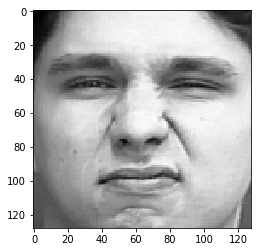

Sequence:  S064_003
Predicted:  neutral
Actual:  happiness


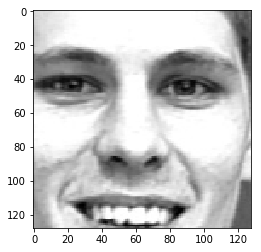

Sequence:  S064_003
Predicted:  fear
Actual:  happiness


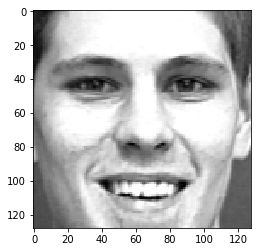

Sequence:  S078_004
Predicted:  neutral
Actual:  happiness


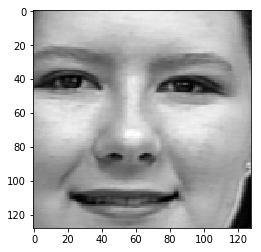

Sequence:  S133_003
Predicted:  sadness
Actual:  anger


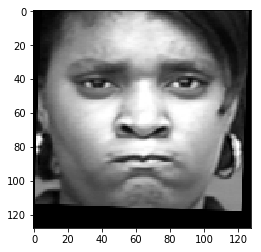

Sequence:  S124_003
Predicted:  sadness
Actual:  fear


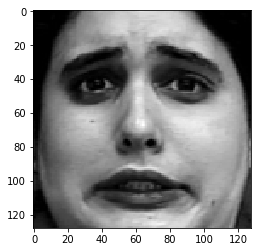

Sequence:  S095_010
Predicted:  neutral
Actual:  sadness


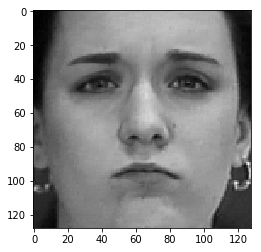

Sequence:  S095_010
Predicted:  neutral
Actual:  sadness


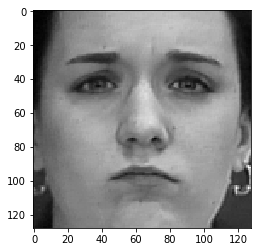

Sequence:  S061_004
Predicted:  anger
Actual:  disgust


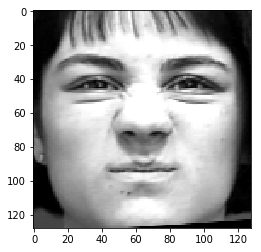

Sequence:  S074_001
Predicted:  surprise
Actual:  fear


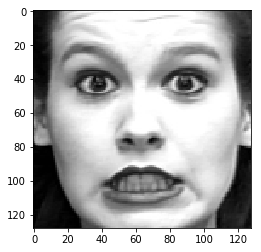

Sequence:  S074_001
Predicted:  surprise
Actual:  fear


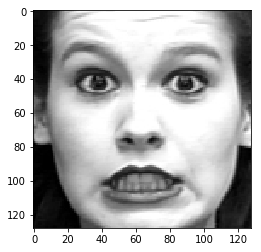

Sequence:  S080_005
Predicted:  neutral
Actual:  sadness


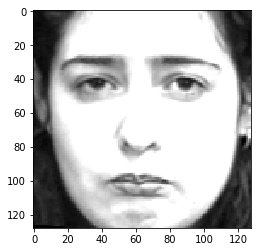

Sequence:  S080_005
Predicted:  neutral
Actual:  sadness


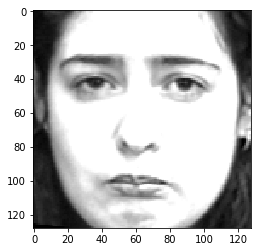

Sequence:  S506_002
Predicted:  neutral
Actual:  contempt


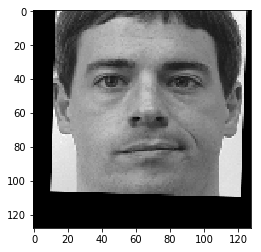

Sequence:  S106_006
Predicted:  disgust
Actual:  happiness


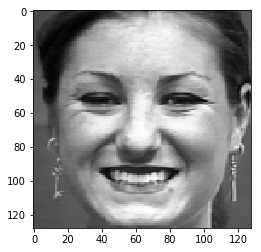

Sequence:  S106_006
Predicted:  disgust
Actual:  happiness


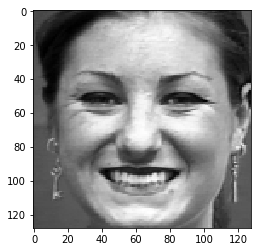

Sequence:  S137_005
Predicted:  anger
Actual:  sadness


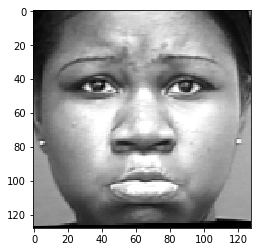

Sequence:  S137_005
Predicted:  anger
Actual:  sadness


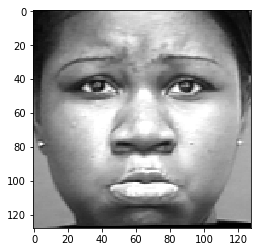

In [41]:
for i in range(length):
    print( 'Sequence: ', sequence_test_incorrect[i] )
    print( 'Predicted: ', emotion_key[pred_incorrect[i]] )
    print( 'Actual: ', emotion_key[y_test_incorrect[i]] )
    image_side = X_test_incorrect[i].shape[1]
    image = np.reshape(X_test_incorrect[i], (image_side, image_side) )
    plt.imshow( image, cmap='gray')
    plt.show()